In [31]:
import faiss
import clip
import ruclip
import torch
import utils
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# инициализируем модель
model_name = 'ruclip'
ruclip_model, preprocess = ruclip.load('ruclip-vit-base-patch32-224', device=device)
ruclip_model.load_state_dict(torch.load('models/ruclip_finetuned.pt', weights_only=True))

/home/student/kholicheva/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


<All keys matched successfully>

In [7]:
# загружаем все имеющиеся данные
df = pd.read_csv('data/total_data_clean.csv')

# вычисляем эмбеддинги
total_image_embeddings, total_text_embeddings = utils.get_full_embeddings(df, ruclip_model, preprocess, model_name, device)

# формируем структуру данных
data = {
    'ids': df['id'].to_list(),
    'image_paths': df['local_image_path'].to_list(),
    'image_embeddings': total_image_embeddings,
    'texts': df['text'].to_list(),
    'text_embeddings': total_text_embeddings,
    'urls': df['url'].to_list()
}

# сохраняем в пикл
with open('embeddings/embeddings_ruclip_finetuned.pkl', 'wb') as file:
    pickle.dump(data, file)

100%|██████████| 166/166 [04:49<00:00,  1.74s/it]


In [ ]:
# открываем пикл с вычисленными эмбеддингами
with open('embeddings/embeddings_ruclip_finetuned.pkl', 'rb') as file:
    data = pickle.load(file)
    image_paths = data['image_paths']
    image_embeddings = data['image_embeddings']

# создаем базу для эффективного поиска
index = faiss.IndexFlatL2(image_embeddings.size(1))
index.add(image_embeddings)

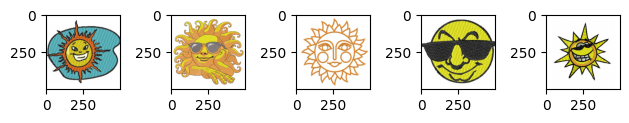

In [49]:
# тестовый запрос
query = 'солнышко улыбается'
query_embedding = utils.get_text_embedding(query, ruclip_model, preprocess, model_name, device)
D, I = index.search(query_embedding, k=5)

# наиболее релевантные изображения
relevant_paths = np.array(image_paths)[I.squeeze()].tolist()
fig, axes = plt.subplots(1, 5)
for ax, path in zip(axes, relevant_paths):
    image = Image.open(path)
    ax.imshow(image)
plt.tight_layout()
plt.show()